In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd 
import os
import random
from keras.api.applications import InceptionV3
import cv2
from keras.api.layers import StringLookup
import tensorflow as tf
from concurrent.futures import ThreadPoolExecutor
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from keras.api.layers import Input, TimeDistributed, LSTM, Dropout, Dense, Masking, Reshape
from keras.api.models import Model
from keras.api.optimizers import Adam
from keras.api.callbacks import ModelCheckpoint
from keras.api.preprocessing import image
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
dataset_path = '../datasets/tp5'

In [4]:
train = pd.read_csv(os.path.join(dataset_path, 'train.csv'))
test = pd.read_csv(os.path.join(dataset_path, 'test.csv'))

In [5]:
for vid in train['video_name']:
    size = os.path.getsize(os.path.join(dataset_path, 'train', vid))
    print(f'video : {vid}, size : {size/1000} kb')

video : v_CricketShot_g08_c01.avi, size : 292.132 kb
video : v_CricketShot_g08_c02.avi, size : 294.336 kb
video : v_CricketShot_g08_c03.avi, size : 205.096 kb
video : v_CricketShot_g08_c04.avi, size : 261.03 kb
video : v_CricketShot_g08_c05.avi, size : 389.568 kb
video : v_CricketShot_g08_c06.avi, size : 321.134 kb
video : v_CricketShot_g08_c07.avi, size : 372.5 kb
video : v_CricketShot_g09_c01.avi, size : 287.62 kb
video : v_CricketShot_g09_c02.avi, size : 263.436 kb
video : v_CricketShot_g09_c03.avi, size : 320.254 kb
video : v_CricketShot_g09_c04.avi, size : 267.27 kb
video : v_CricketShot_g09_c05.avi, size : 302.182 kb
video : v_CricketShot_g09_c06.avi, size : 363.102 kb
video : v_CricketShot_g09_c07.avi, size : 210.084 kb
video : v_CricketShot_g10_c01.avi, size : 470.474 kb
video : v_CricketShot_g10_c02.avi, size : 355.276 kb
video : v_CricketShot_g10_c03.avi, size : 304.658 kb
video : v_CricketShot_g10_c04.avi, size : 205.012 kb
video : v_CricketShot_g10_c05.avi, size : 325.316 k

In [6]:
for vid in test['video_name']:
    size = os.path.getsize(os.path.join(dataset_path, 'test', vid))
    print(f'video : {vid}, size : {size/1000} kb')

video : v_CricketShot_g01_c01.avi, size : 265.132 kb
video : v_CricketShot_g01_c02.avi, size : 356.072 kb
video : v_CricketShot_g01_c03.avi, size : 369.472 kb
video : v_CricketShot_g01_c04.avi, size : 275.182 kb
video : v_CricketShot_g01_c05.avi, size : 369.376 kb
video : v_CricketShot_g01_c06.avi, size : 285.596 kb
video : v_CricketShot_g01_c07.avi, size : 266.214 kb
video : v_CricketShot_g02_c01.avi, size : 282.654 kb
video : v_CricketShot_g02_c02.avi, size : 294.998 kb
video : v_CricketShot_g02_c03.avi, size : 335.092 kb
video : v_CricketShot_g02_c04.avi, size : 278.102 kb
video : v_CricketShot_g02_c05.avi, size : 456.29 kb
video : v_CricketShot_g02_c06.avi, size : 338.534 kb
video : v_CricketShot_g02_c07.avi, size : 319.17 kb
video : v_CricketShot_g03_c01.avi, size : 374.054 kb
video : v_CricketShot_g03_c02.avi, size : 431.122 kb
video : v_CricketShot_g03_c03.avi, size : 383.668 kb
video : v_CricketShot_g03_c04.avi, size : 419.844 kb
video : v_CricketShot_g03_c05.avi, size : 428.03

In [7]:
print(train.head()) # Print the 5 first line of the df 
print('---------------------')
print(train.describe()) # Print some stats on our df
print('------------------------------')
print(train.info()) # Print a summary of our df 

                  video_name          tag
0  v_CricketShot_g08_c01.avi  CricketShot
1  v_CricketShot_g08_c02.avi  CricketShot
2  v_CricketShot_g08_c03.avi  CricketShot
3  v_CricketShot_g08_c04.avi  CricketShot
4  v_CricketShot_g08_c05.avi  CricketShot
---------------------
                       video_name    tag
count                         594    594
unique                        594      5
top     v_CricketShot_g08_c01.avi  Punch
freq                            1    121
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594 entries, 0 to 593
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   video_name  594 non-null    object
 1   tag         594 non-null    object
dtypes: object(2)
memory usage: 9.4+ KB
None


In [8]:
targets = train['tag'].unique()
print(targets)

['CricketShot' 'PlayingCello' 'Punch' 'ShavingBeard' 'TennisSwing']


In [9]:
def feature_extractor():
    model = InceptionV3(
                include_top=False,
                weights="imagenet",
                input_tensor=None,
                input_shape=None,
                pooling='avg',
                name="inception_v3",
            )
    model.trainable = False
    return model

In [10]:
layer = StringLookup(vocabulary=targets, num_oov_indices=0, output_mode='one_hot')

In [11]:
train_y = tf.reshape(layer(train['tag']), shape=(-1,5))
test_y = tf.reshape(layer(test['tag']), shape=(-1, 5))

In [12]:
print(train_y)
print('-------------------')
print(test_y)

tf.Tensor(
[[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]], shape=(594, 5), dtype=int64)
-------------------
tf.Tensor(
[[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]], shape=(224, 5), dtype=int64)


In [13]:
def crop_center_square(frame):
    y, x = frame.shape[:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    
    return frame[start_y:start_y + min_dim, start_x:start_x + min_dim]

In [14]:
def load_video(video_path, fps, shape=(224,224)):

    cap = cv2.VideoCapture(video_path)
    nb_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    step = nb_frames // fps
    
    frames = []
    for frame_count in range(fps):
        
        frame_index = frame_count * step
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        ret, frame = cap.read()
        frame = crop_center_square(frame)
        frame = cv2.resize(frame, shape)

        frames.append(frame)
    
    cap.release()
    return np.array(frames) / 255.0

In [15]:
def process_video(video_path):
    MAX_SEQ_LENGTH = 25
    NUM_FEATURES = 2048
    shape = (224, 224)
    model = feature_extractor()
    frames = load_video(video_path, MAX_SEQ_LENGTH, shape)
    frames = frames[None, ...]
    
    temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH), dtype='bool')
    temp_frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype='float32')

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            temp_frame_features[i, j, :] = model.predict(batch[None, j, :], verbose=0)
            temp_frame_mask[i, :length] = 1
    
    return temp_frame_features.squeeze(), temp_frame_mask.squeeze()

In [16]:
def prepare_all_video(path):    
    all_features = []
    all_masks = []
    videos_path = [os.path.join(path, vid) for vid in os.listdir(path)]
    print(videos_path)
    with ThreadPoolExecutor(max_workers=16) as exec:
        results = list(tqdm(exec.map(process_video, videos_path), total=len(videos_path)))
    
    for features, mask in results:
        all_features.append(features)
        all_masks.append(mask)
    return np.array(all_features), np.array(all_masks)

In [ ]:
train_path = '../datasets/tp5/train'
test_path = '../datasets/tp5/test'

train_features, train_masks = prepare_all_video(train_path)
test_features, test_masks = prepare_all_video(test_path)

['../datasets/tp5/train\\v_CricketShot_g08_c01.avi', '../datasets/tp5/train\\v_CricketShot_g08_c02.avi', '../datasets/tp5/train\\v_CricketShot_g08_c03.avi', '../datasets/tp5/train\\v_CricketShot_g08_c04.avi', '../datasets/tp5/train\\v_CricketShot_g08_c05.avi', '../datasets/tp5/train\\v_CricketShot_g08_c06.avi', '../datasets/tp5/train\\v_CricketShot_g08_c07.avi', '../datasets/tp5/train\\v_CricketShot_g09_c01.avi', '../datasets/tp5/train\\v_CricketShot_g09_c02.avi', '../datasets/tp5/train\\v_CricketShot_g09_c03.avi', '../datasets/tp5/train\\v_CricketShot_g09_c04.avi', '../datasets/tp5/train\\v_CricketShot_g09_c05.avi', '../datasets/tp5/train\\v_CricketShot_g09_c06.avi', '../datasets/tp5/train\\v_CricketShot_g09_c07.avi', '../datasets/tp5/train\\v_CricketShot_g10_c01.avi', '../datasets/tp5/train\\v_CricketShot_g10_c02.avi', '../datasets/tp5/train\\v_CricketShot_g10_c03.avi', '../datasets/tp5/train\\v_CricketShot_g10_c04.avi', '../datasets/tp5/train\\v_CricketShot_g10_c05.avi', '../dataset

100%|██████████| 594/594 [37:27<00:00,  3.78s/it] 


['../datasets/tp5/test\\v_CricketShot_g01_c01.avi', '../datasets/tp5/test\\v_CricketShot_g01_c02.avi', '../datasets/tp5/test\\v_CricketShot_g01_c03.avi', '../datasets/tp5/test\\v_CricketShot_g01_c04.avi', '../datasets/tp5/test\\v_CricketShot_g01_c05.avi', '../datasets/tp5/test\\v_CricketShot_g01_c06.avi', '../datasets/tp5/test\\v_CricketShot_g01_c07.avi', '../datasets/tp5/test\\v_CricketShot_g02_c01.avi', '../datasets/tp5/test\\v_CricketShot_g02_c02.avi', '../datasets/tp5/test\\v_CricketShot_g02_c03.avi', '../datasets/tp5/test\\v_CricketShot_g02_c04.avi', '../datasets/tp5/test\\v_CricketShot_g02_c05.avi', '../datasets/tp5/test\\v_CricketShot_g02_c06.avi', '../datasets/tp5/test\\v_CricketShot_g02_c07.avi', '../datasets/tp5/test\\v_CricketShot_g03_c01.avi', '../datasets/tp5/test\\v_CricketShot_g03_c02.avi', '../datasets/tp5/test\\v_CricketShot_g03_c03.avi', '../datasets/tp5/test\\v_CricketShot_g03_c04.avi', '../datasets/tp5/test\\v_CricketShot_g03_c05.avi', '../datasets/tp5/test\\v_Crick

 23%|██▎       | 52/224 [03:44<08:16,  2.89s/it] 

 58%|█████▊    | 131/224 [08:57<05:50,  3.77s/it]

In [22]:
with open('./train_features.pkl', 'wb') as f:
    pickle.dump(train_features, f)
    
with open('./train_masks.pkl', 'wb') as f:
    pickle.dump(train_masks, f)

with open('./test_features.pkl', 'wb') as f:
    pickle.dump(test_features, f)

with open('./test_masks.pkl', 'wb') as f:
    pickle.dump(test_masks, f)

In [25]:
print(f'train_ft : {train_features.shape}, train_msk : {train_masks.shape}')
print(f'test_ft : {test_features.shape}, test_msk : {test_masks.shape}')

train_ft : (594, 25, 2048), train_msk : (594, 25)
test_ft : (224, 25, 2048), test_msk : (224, 25)


In [48]:
def sequence_model():
    
    features_input = Input(shape=(25, 2048))

    x = TimeDistributed(Dense(512, activation='relu'))(features_input)
    x = TimeDistributed(Dense(256, activation='relu'))(x)

    x = LSTM(512, return_sequences=True)(x)
    x = LSTM(256, return_sequences=True)(x)
    x = LSTM(128)(x)

    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(len(layer.get_vocabulary()), activation='softmax')(x)

    model = Model(features_input, outputs=output)

    opt = Adam(learning_rate=0.0005)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [66]:
def run_experiment(train_features, train_labels, test_features, test_labels):
    model = sequence_model()
    
    train_features = np.array(train_features)
    train_labels = np.array(train_labels)

    indices = np.arange(len(train_features))
    np.random.shuffle(indices)

    train_features = train_features[indices]
    train_labels = train_labels[indices]

    split = int(0.7 * len(train_features))
    train_features, val_features = train_features[:split], train_features[split:]
    train_labels, val_labels = train_labels[:split], train_labels[split:]
    
    checkpoint_path = './models_checkpoints/best_model.keras'
    checkpoint = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor="val_accuracy")
    print(model.summary())
    
    history = model.fit(
        x=train_features,
        y=train_labels,
        validation_data=(val_features, val_labels),
        epochs=20,
        callbacks=[checkpoint]
    )
    
    model.load_weights(checkpoint_path)
    evaluation = model.evaluate(
        x=test_features,
        y=test_labels
    )
    
    predictions = np.argmax(model.predict(x=test_features), axis=1)
    
    cm = confusion_matrix(np.argmax(test_y, axis=1), predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    print(f'Model evaluation : {evaluation}')

    return history.history

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 25, 2048)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_26             │ (None, 25, 512)        │     1,049,088 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_27             │ (None, 25, 256)        │       131,328 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_39 (LSTM)                  │ (None, 25, 512)        │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_40 (LSTM)                  │ (None, 25, 256)        │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_41 (LSTM)                  │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,757,061 (14.33 MB)

 Trainable params: 3,757,061 (14.33 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 322ms/step - accuracy: 0.2076 - loss: 1.6227 - val_accuracy: 0.4134 - val_loss: 1.3855
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - accuracy: 0.4255 - loss: 1.3516 - val_accuracy: 0.7430 - val_loss: 0.8381
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.7498 - loss: 0.7601 - val_accuracy: 0.8603 - val_loss: 0.4843
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 249ms/step - accuracy: 0.9075 - loss: 0.3817 - val_accuracy: 0.9330 - val_loss: 0.2114
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - accuracy: 0.9517 - loss: 0.2207 - val_accuracy: 0.9609 - val_loss: 0.1923
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.9633 - loss: 0.1690 - val_accuracy: 0.8547 - val_loss: 0.4257
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.9679 - loss: 0.1682 - val_accuracy: 0.9721 - val_loss: 0.1224
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.9776 - loss: 0.1441 - val_accura

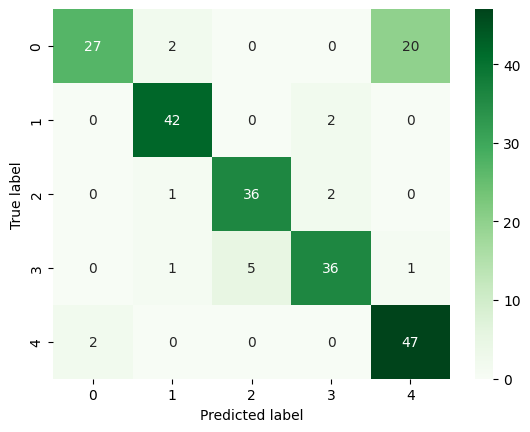

In [67]:
history = run_experiment(train_features, train_y, test_features, test_y)

In [71]:
print(history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


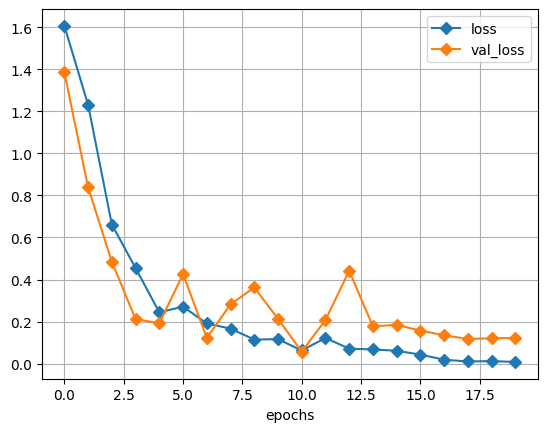

In [77]:
plt.plot(history['loss'], label='loss', marker='D')
plt.plot(history['val_loss'], label='val_loss', marker='D')
plt.xlabel('epochs')
plt.grid()
plt.legend()

In [ ]:
plt.plot(history['loss'], label='loss', marker='D')
plt.plot(history['val_loss'], label='val_loss', marker='D')
plt.xlabel('epochs')
plt.grid()
plt.legend()

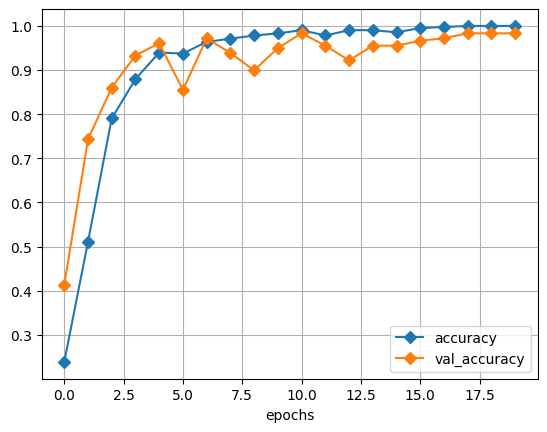

In [78]:
plt.plot(history['accuracy'], label='accuracy', marker='D')
plt.plot(history['val_accuracy'], label='val_accuracy', marker='D')
plt.xlabel('epochs')
plt.grid()
plt.legend()

We can see that i have good resultes in both training and validation metrics because I shuffled them so it generalize well on our data.

We also have  overfitting our data because our test accuracy is only 83% which is a lot lower than our training accuracy

In [82]:
def prepare_single_video(video_path):
    MAX_SEQ_LENGTH = 25
    NUM_FEATURES = 2048
    shape = (100, 100)
    model = feature_extractor()
    frames = load_video(video_path, MAX_SEQ_LENGTH, shape)
    frames = frames[None, ...]
    
    temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH), dtype='bool')
    temp_frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype='float32')

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            temp_frame_features[i, j, :] = model.predict(batch[None, j, :], verbose=0)
            temp_frame_mask[i, :length] = 1
    
    return temp_frame_features.squeeze()[None, ...], temp_frame_mask.squeeze()[None, ...]

In [86]:
df_test = pd.read_csv(os.path.join(dataset_path, 'test.csv'))

In [107]:
idx = 101
print(df_test.loc[idx].to_list())

['v_Punch_g02_c04.avi', 'Punch']


In [219]:
def sequence_prediction(df_test, video_idx=0, video_path=None):
    if video_idx != None:
        video_path = os.path.join('../datasets/tp5/test', df_test.loc[video_idx].to_list()[0])
    print('video_path : ', video_path)
    
    frames_features, frames_masks = prepare_single_video(video_path)
    
    test_labels = test['tag'].unique()
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(test_labels)
    
    model = sequence_model()
    model.load_weights('./models_checkpoints/best_model.keras')
    prediction = model.predict(frames_features)[0]

    prediction_class = np.argmax(prediction)
    prob = prediction[prediction_class]
    og_label = label_encoder.inverse_transform([prediction_class])
    return (og_label, prob)
    
    

In [221]:
prediction = sequence_prediction(df_test, 150)

print(f'class : {prediction[0]}, proba : {prediction[1]}, true_class')

video_path :  ../datasets/tp5/test\v_ShavingBeard_g04_c01.avi


c:\Users\Jalil\Desktop\Ecole\M2TSI\tpenv\lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 36 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
class : ['ShavingBeard'], proba : 0.9968135952949524, true_class


We ve seen that we have overfitted a bit out training data so to reduce this overfitting maybe we can reduce the number of weights or increase our dataset with augmentation but the second may be complicated with videos.

I made a small mistake, I use the model with (100, 100) images